# Table of Contents
1. [Introduction](#introduction)
2. [Retrieve jobs from Ceph and map to JSON dataframe](#display-jobs-in-dataframe)

## Introduction <a name="introduction"></a>

**Overview**

The purpose of this notebook is to give context to software stacks with errors analyzed. Currently grafana metrics from the SolverResultsStore show over 661k results. This notebook filters for documents with solver errors. Within the results, there are currently three different solvers:
- solver-rhel-8.0-py36
- solver-fedora-31-py38
- solver-fedora31-py37

Each solver has around 20k - 30k results with solver error. These errors are classified:
- unparseable
- unsolvable (due to missing packages/missing components)
- other


## Retrieve jobs from Ceph and map to JSON dataframe <a name="display-jobs-in-dataframe"></a>

In [747]:
%env THOTH_DEPLOYMENT_NAME     thoth-psi-stage
%env THOTH_CEPH_BUCKET         thoth
%env THOTH_CEPH_BUCKET_PREFIX  data/thoth
%env THOTH_S3_ENDPOINT_URL     https://s3.upshift.redhat.com 

env: THOTH_DEPLOYMENT_NAME=thoth-psi-stage
env: THOTH_CEPH_BUCKET=thoth
env: THOTH_CEPH_BUCKET_PREFIX=data/thoth
env: THOTH_S3_ENDPOINT_URL=https://s3.upshift.redhat.com


In [748]:
from pprint import pprint
import random
from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from pandas.io.json import json_normalize
import json
import pandas as pd
from IPython.display import display, Markdown
from thoth.storages import SolverResultsStore
from thoth.storages.result_base import ResultStorageBase
from IPython.display import clear_output
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


### Functions

In [749]:
def printmd(string):
    """Alternate print function implementing markdown formatting
    
    :param string: string to print.
    """
    display(Markdown(string))

In [750]:
def get_solver_document(num_of_documents):
    #DO NOT RUN THIS
    count_solver_error = 0
    count_no_error = 0
    solver_results = []
    for document_id in solver_store.get_document_listing():
        document = solver_store.retrieve_document(document_id)
        if len(document.get('result').get('errors')) is not 0:
            solver_results.append(document)
            count_solver_error +=1
        else:
            count_no_error +=1
        clear_output()
        print("With error:", count_solver_error, "Without error:", count_no_error)
        if(count_solver_error == num_of_documents):
            break
    return solver_results

In [751]:
def get_list_of_columns_to_analyze(df_solver_results: pd.DataFrame):
    lst_columns_to_analyze = []
    printmd("#### Columns to analyze, Unique Value Count")
    for i in df_solver_results:
        try:
            value_count = len(df_solver_results.groupby(i).count())

            if (value_count > 1):
                print(i, value_count)
                lst_columns_to_analyze.append(i)
        except TypeError:
            #Groups every column by unique values if values are in list or dict formats
            try:
                value_count = len(pd.Series(df_solver_results[i].values).apply(tuple).unique())
                if (value_count > 1):
                    print(i, value_count)
                    lst_columns_to_analyze.append(i)
            except TypeError:
                l = (list(df_solver_results[i].values))
                value_count = len([i for n, i in enumerate(l) if i not in l[n + 1:]])
                if (value_count > 1):
                    print(i, value_count)
                    lst_columns_to_analyze.append(i)
                pass
    return lst_columns_to_analyze


In [752]:
#remove punctuation
def remove_punctuation(text):
    no_punct = "".join([c for c in text if c not in string.punctuation])
    return no_punct

#tokenization
tokenizer = RegexpTokenizer(r'\w+')

#Stopwords
def stopwords_remove(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

#remove list
def remove_list(text):
    no_list = ','.join(text)
    return no_list

#remove next line
def remove_next_line(text):
    new_text = text.split('\n')
    return new_text

#remove spacing runs
def remove_spacing_runs(text):
    clean_text = re.sub("\s\s+" , " ", text)
    return clean_text

In [ ]:
def distance_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [971]:
def get_data_from_cluster(df_processed, clusters, cluster_number):
    indices = [i for i, x in enumerate(clusters) if x == cluster_number]
    df_grouped = df_processed.iloc[indices]
    print(len(df_grouped))
    return df_grouped

In [972]:
def get_message_component(identifier: str, error_message: list):
    for i in error_message:
        if identifier in i.lstrip():
            list_element = i
    return list_element

### Load Data

In [753]:
#Connect to solver results store
solver_store = SolverResultsStore()
solver_store.connect()

In [5]:
#DO NOT RUN THIS- gets all solver ids
solver_results = []
solver_ids = []
for document_id in solver_store.get_document_listing():
    solver_ids.append(document_id)
    

In [231]:
len(solver_ids)

664719

In [251]:
#Sample of what a solver id looks like
solver_ids[0:5]

['solver-fedora-31-py37-000020c0',
 'solver-fedora-31-py37-00006c30',
 'solver-fedora-31-py37-00007021',
 'solver-fedora-31-py37-00007e6e',
 'solver-fedora-31-py37-0002ab98']

In [754]:
#Print the solvers included in the data
solvers = []
for elem in solver_ids:
    solvers.append(elem.rsplit("-", maxsplit=1)[0])
unique_solvers = str(list(set(solvers)))

printmd("### Solvers to analyze")
printmd(unique_solvers)

### Solvers to analyze

['solver-rhel-8.0-py36', 'solver-fedora-31-py37', 'solver-rhel-8-py36', 'solver-fedora-31-py38']

In [238]:
#Get set of solver documents to analyze
solver_results = get_solver_document(2000)

With error: 2000 Without error: 10545


In [302]:
len(solver_results)

2000

In [433]:
#Example of a solver result error
text = solver_results[255]['result']['errors'][0]['details']['message']

### Display full Error

In [884]:
text

'Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:\n   command: /home/solver/venv/bin/python3 -u -c \'import sys, setuptools, tokenize; sys.argv[0] = \'"\'"\'/tmp/pip-install-q__c9wn6/libsass/setup.py\'"\'"\'; __file__=\'"\'"\'/tmp/pip-install-q__c9wn6/libsass/setup.py\'"\'"\';f=getattr(tokenize, \'"\'"\'open\'"\'"\', open)(__file__);code=f.read().replace(\'"\'"\'\\r\\n\'"\'"\', \'"\'"\'\\n\'"\'"\');f.close();exec(compile(code, __file__, \'"\'"\'exec\'"\'"\'))\' bdist_wheel -d /tmp/pip-wheel-4yf04q2t --python-tag cp37\n       cwd: /tmp/pip-install-q__c9wn6/libsass/\n  Complete output (21 lines):\n  running bdist_wheel\n  running build\n  running build_py\n  creating build\n  creating build/lib.linux-x86_64-3.7\n  copying sass.py -> build/lib.linux-x86_64-3.7\n  copying sassc.py -> build/lib.linux-x86_64-3.7\n  copying sasstests.py -> build/lib.linux-x86_64-3.7\n  creating build/lib.linux-x86_64-3.7/sassutils\n  copying sassutils/distutils.py

In [885]:
x = remove_next_line(text)

In [886]:
#split up components of error message by the \n valueb
x

['Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:',
 '   command: /home/solver/venv/bin/python3 -u -c \'import sys, setuptools, tokenize; sys.argv[0] = \'"\'"\'/tmp/pip-install-q__c9wn6/libsass/setup.py\'"\'"\'; __file__=\'"\'"\'/tmp/pip-install-q__c9wn6/libsass/setup.py\'"\'"\';f=getattr(tokenize, \'"\'"\'open\'"\'"\', open)(__file__);code=f.read().replace(\'"\'"\'\\r\\n\'"\'"\', \'"\'"\'\\n\'"\'"\');f.close();exec(compile(code, __file__, \'"\'"\'exec\'"\'"\'))\' bdist_wheel -d /tmp/pip-wheel-4yf04q2t --python-tag cp37',
 '       cwd: /tmp/pip-install-q__c9wn6/libsass/',
 '  Complete output (21 lines):',
 '  running bdist_wheel',
 '  running build',
 '  running build_py',
 '  creating build',
 '  creating build/lib.linux-x86_64-3.7',
 '  copying sass.py -> build/lib.linux-x86_64-3.7',
 '  copying sassc.py -> build/lib.linux-x86_64-3.7',
 '  copying sasstests.py -> build/lib.linux-x86_64-3.7',
 '  creating build/lib.linux-x86_64-3.7/sassut

## Components of one error message

In [919]:
identifier = 'Command exited with non-zero status code (1):'
get_message_component(identifier, x)

'Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:'

In [920]:
identifier = 'command:'
get_message_component(identifier, x)

'     command: /home/solver/venv/bin/python3 -u -c \'import sys, setuptools, tokenize; sys.argv[0] = \'"\'"\'/tmp/pip-install-q__c9wn6/libsass/setup.py\'"\'"\'; __file__=\'"\'"\'/tmp/pip-install-q__c9wn6/libsass/setup.py\'"\'"\';f=getattr(tokenize, \'"\'"\'open\'"\'"\', open)(__file__);code=f.read().replace(\'"\'"\'\\r\\n\'"\'"\', \'"\'"\'\\n\'"\'"\');f.close();exec(compile(code, __file__, \'"\'"\'exec\'"\'"\'))\' install --record /tmp/pip-record-tuf1nrca/install-record.txt --single-version-externally-managed --compile --install-headers /home/solver/venv/include/site/python3.7/libsass'

In [921]:
identifier = 'ERROR:'
get_message_component(identifier, x)

'ERROR: Command errored out with exit status 1: /home/solver/venv/bin/python3 -u -c \'import sys, setuptools, tokenize; sys.argv[0] = \'"\'"\'/tmp/pip-install-q__c9wn6/libsass/setup.py\'"\'"\'; __file__=\'"\'"\'/tmp/pip-install-q__c9wn6/libsass/setup.py\'"\'"\';f=getattr(tokenize, \'"\'"\'open\'"\'"\', open)(__file__);code=f.read().replace(\'"\'"\'\\r\\n\'"\'"\', \'"\'"\'\\n\'"\'"\');f.close();exec(compile(code, __file__, \'"\'"\'exec\'"\'"\'))\' install --record /tmp/pip-record-tuf1nrca/install-record.txt --single-version-externally-managed --compile --install-headers /home/solver/venv/include/site/python3.7/libsass Check the logs for full command output.'

In [922]:
identifier = 'error:'
get_message_component(identifier, x)

"    error: command 'gcc' failed with exit status 1"

In [923]:
identifier = 'unable to execute'
get_message_component(identifier, x)

"    unable to execute 'gcc': No such file or directory"

In [927]:
#Cannot use identifier cwd: for this because info spreads 
#across several list elements
x[2:-6]

['       cwd: /tmp/pip-install-q__c9wn6/libsass/',
 '  Complete output (21 lines):',
 '  running bdist_wheel',
 '  running build',
 '  running build_py',
 '  creating build',
 '  creating build/lib.linux-x86_64-3.7',
 '  copying sass.py -> build/lib.linux-x86_64-3.7',
 '  copying sassc.py -> build/lib.linux-x86_64-3.7',
 '  copying sasstests.py -> build/lib.linux-x86_64-3.7',
 '  creating build/lib.linux-x86_64-3.7/sassutils',
 '  copying sassutils/distutils.py -> build/lib.linux-x86_64-3.7/sassutils',
 '  copying sassutils/builder.py -> build/lib.linux-x86_64-3.7/sassutils',
 '  copying sassutils/__init__.py -> build/lib.linux-x86_64-3.7/sassutils',
 '  copying sassutils/wsgi.py -> build/lib.linux-x86_64-3.7/sassutils',
 '  running build_ext',
 "  building '_sass' extension",
 '  creating build/temp.linux-x86_64-3.7',
 '  creating build/temp.linux-x86_64-3.7/libsass',
 '  creating build/temp.linux-x86_64-3.7/libsass/src',
 '  gcc -pthread -Wno-unused-result -Wsign-compare -DDYNAMIC_AN

In [257]:
#Turn Solver results into a dataframe
df_solver_results = json_normalize(solver_results, sep = "_")

In [258]:
#Gives uniqe counts of values in each column of the data table
lst_columns_to_analyze = get_list_of_columns_to_analyze(df_solver_results)

#### Columns to analyze, Unique Value Count

metadata_arguments_python_index 3
metadata_arguments_python_requirements 2000
metadata_datetime 2000
metadata_document_id 2000
metadata_duration 49
metadata_hostname 2000
metadata_timestamp 1734
result_errors 2000
result_tree 28
result_unresolved 38


In [399]:
#Obtain dataframe only of column that needs analysis
df_solver_results_to_analyze = df_solver_results[lst_columns_to_analyze]

In [400]:
df_solver_results_to_analyze.head(3)

metadata_arguments_python_index metadata_arguments_python_requirements  \
0  https://pypi.org/simple         json2html==1.1.0                        
1  https://pypi.org/simple         guillotina==1.3.0                       
2  https://pypi.org/simple         documenttemplate==2.13.4                

            metadata_datetime            metadata_document_id  \
0  2019-12-27T17:17:58.575766  solver-fedora-31-py37-00087c38   
1  2019-12-24T16:38:05.389304  solver-fedora-31-py37-0009d0a4   
2  2019-12-24T16:38:10.581721  solver-fedora-31-py37-000d5133   

   metadata_duration                     metadata_hostname  \
0  2                  solver-fedora-31-py37-00087c38-hsv2c   
1  4                  solver-fedora-31-py37-0009d0a4-qdpqp   
2  2                  solver-fedora-31-py37-000d5133-kxp5g   

   metadata_timestamp  \
0  1577467078           
1  1577205485           
2  1577205490           

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

# Components of all error messages

In [633]:
df_error_components = pd.DataFrame()

In [634]:
def get_ERROR(text):
    value = "Command exited with non-zero status code (1):"
    if value in text:
        text = text.replace(value, "")
    text = ' '.join(text.split())
    return text

In [635]:
df_error_components['result_errors'] = df_solver_results_to_analyze['result_errors']
df_error_components['message'] = df_error_components.apply(lambda row: row.result_errors[0]['details']['message'], axis=1)
df_error_components['tokenized_message'] = df_error_components.apply(lambda row: remove_next_line(row.message),axis = 1)
df_error_components['exit_status'] = df_error_components.apply(lambda row: row.tokenized_message[0],axis = 1)
df_error_components['exit_status_ERROR'] = df_error_components.apply(lambda row: get_ERROR(row.exit_status), axis = 1)
df_error_components['command'] = df_error_components["tokenized_message"].str[1]
df_error_components['ERROR'] = df_error_components["tokenized_message"].str[-2]
df_error_components['error_info'] = df_error_components["tokenized_message"].str[-4]
df_error_components['error_label'] = df_error_components["tokenized_message"].str[-5]
df_error_components['cwd_info'] = df_error_components["tokenized_message"].str[2:-6]

In [722]:
df_error_components['error_for_analysis'] = df_error_components['error_info'] + df_error_components['error_label']

In [928]:
df_error_components.head()

result_errors  \
0  [{'details': {'command': '/home/solver/venv/bin/python3 -m pip install --force-reinstall --no-cache-dir --no-deps json2html==1.1.0 --index-url "https://pypi.org/simple"  --trusted-host pypi.org', 'message': 'Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:
     command: /home/solver/venv/bin/python3 -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-1eq417ji/json2html/setup.py'"'"'; __file__='"'"'/tmp/pip-install-1eq417ji/json2html/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-install-1eq417ji/json2html/pip-egg-info
         cwd: /tmp/pip-install-1eq417ji/json2html/
    Complete output (5 lines):
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/tmp/pip-install-1eq417ji/json2html/setup.py", line 17, in <module>
        long_description=open('README.md').read(),
    FileNotFoundError: [Errno 2] No such file or directory: 'README.md'
    ----------------------------------------
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.
', 'return_code': 1, 'stderr': '    ERROR: Command errored out with exit status 1:
     command: /home/solver/venv/bin/python3 -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-1eq417ji/json2html/setup.py'"'"'; __file__='"'"'/tmp/pip-install-1eq417ji/json2html/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-install-1eq417ji/json2html/pip-egg-info
         cwd: /tmp/pip-install-1eq417ji/json2html/
    Complete output (5 lines):
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/tmp/pip-install-1eq417ji/json2html/setup.py", line 17, in <module>
        long_description=open('README.md').read(),
    FileNotFoundError: [Errno 2] No such file or directory: 'README.md'
    ----------------------------------------
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.
', 'stdout': 'Collecting json2html==1.1.0
  Downloading https://files.pythonhosted.org/packages/70/3b/a0866f9a1ca7f3347546614770221a0061a8ea0ac5b7df053c6e55273ac8/json2html-1.1.0.tar.gz
', 'timeout': 60}, 'index_url': 'https://pypi.org/simple', 'is_provided_package': True, 'is_provided_package_version': True, 'package_name': 'json2html', 'package_version': '1.1.0', 'type': 'command_error'}]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [725]:
get_list_of_columns_to_analyze(df_error_components)

#### Columns to analyze, Unique Value Count

result_errors 2000
message 1990
tokenized_message 1990
exit_status 430
exit_status_ERROR 428
command 1973
ERROR 868
error_info 374
error_label 421
cwd_info 1535
exit_status_ERROR_processed 428
error_info_processed 371
message_processed 374
error_for_analysis 541


['result_errors',
 'message',
 'tokenized_message',
 'exit_status',
 'exit_status_ERROR',
 'command',
 'ERROR',
 'error_info',
 'error_label',
 'cwd_info',
 'exit_status_ERROR_processed',
 'error_info_processed',
 'message_processed',
 'error_for_analysis']

In [724]:
df_error_components['exit_status_ERROR'].unique()

array(['ERROR: Command errored out with exit status 1:',
       'ERROR: Could not find a version that satisfies the requirement cbapi==0.9.0 (from versions: 0.8.0, 0.8.1, 0.9.1, 0.9.2, 0.9.3, 0.9.4, 0.9.5, 0.9.6, 0.9.7, 0.9.8, 1.0.0, 1.0.1, 1.1.0, 1.1.1, 1.2.0, 1.3.0, 1.3.1, 1.3.2, 1.3.3, 1.3.4, 1.3.5, 1.3.6, 1.4.0, 1.4.1, 1.4.2, 1.4.3, 1.4.4, 1.4.5, 1.5.0, 1.5.1, 1.5.2, 1.5.3, 1.5.4, 1.5.5, 1.5.6, 1.6.0)',
       'ERROR: Could not find a version that satisfies the requirement lupa==0.2 (from versions: 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.10, 0.11, 0.12, 0.13, 0.13.1, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 1.0b1, 1.0, 1.0.1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9)',
       'Failed to successfully execute function in Python interpreter: Fatal Python error: initsite: Failed to import the site module',
       'ERROR: Could not find a version that satisfies the requirement netifaces==0.6 (from versions: 0.8, 0.10.0, 0.10.1, 0.10.2, 0.10.3, 0.10.4, 0.10.5, 0.10.6, 0.10.7, 0.10.8, 0

In [651]:
df_error_components['error_info'].unique()

array(["    FileNotFoundError: [Errno 2] No such file or directory: 'README.md'",
       "    error: command 'gcc' failed with exit status 1",
       "    NameError: name 'execfile' is not defined",
       '    SyntaxError: invalid syntax',
       "    ModuleNotFoundError: No module named 'numpy'",
       "    FileNotFoundError: [Errno 2] No such file or directory: '/System/Library/CoreServices/SystemVersion.plist'",
       "    FileNotFoundError: [Errno 2] No such file or directory: 'cc': 'cc'",
       '    TypeError: expected str, bytes or os.PathLike object, not _io.TextIOWrapper',
       nan,
       "    FileNotFoundError: [Errno 2] No such file or directory: '/tmp/pip-install-se5rp040/premailer/setup.py'",
       "    NameError: name 'file' is not defined",
       "    ModuleNotFoundError: No module named 'auxlib'", '    ',
       '    SyntaxError: Missing parentheses in call to \'print\'. Did you mean print("Biopython requires Python 2.4 or better.  Python %d.%d detected" % \\)?'

In [686]:
#Remove stopwords from exit_status_Error column
def process_exit_status_ERROR(text):
    if "ERROR:" in text:
        text = text.replace("ERROR: ", "")
    if "Command errored out with exit status 1:" in text:
        text = text.replace("Command errored out with exit status 1:", "exitStatus1")
    if "Could not find a version that satisfies the requirement" in text:
        text = text.replace("Could not find a version that satisfies the requirement", "CouldNotFindVersionRequirement")
    if " (from versions:" in text:
        text = text.split(" (from versions: ")
    if len(text) == 2:
        text = text[0]
    return text

In [687]:
#Remove stopwords from error info
def process_error_info(text):
    if isinstance(text, str):
        text = ' '.join(text.split())
        if " [Errno 2] No such file or directory: " in text:
            text = text.replace(" [Errno 2] No such file or directory: ", " ")
        if "NameError:" in text:
            text = text.replace(" name ", " ")
            text = text.replace(" is not defined", "")
        if "ModuleNotFoundError:" in text:
            text = text.replace("No module named ", "")
    return text

In [699]:
def message_processing(text):
    if not isinstance(text, str):
        text = ""
        
    return text

In [700]:
df_error_components['exit_status_ERROR_processed'] = df_error_components.apply(lambda row: remove_stopwords(row.exit_status_ERROR),axis = 1)
df_error_components['error_info_processed'] = df_error_components.apply(lambda row: process_error_info(row.error_info),axis = 1)
df_error_components["message_processed"] = df_error_components["exit_status_ERROR_processed"] + " " + df_error_components["error_info_processed"]
df_error_components["message_processed"] = df_error_components.apply(lambda row: message_processing(row.message_processed),axis = 1)

In [932]:
df_processed = df_error_components
df_processed = df_processed.drop(["tokenized_message", "message", "result_errors", "cwd_info",], axis=1)

In [933]:
df_processed

exit_status  \
0     Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
1     Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
2     Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
3     Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
4     Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:                                                                                                                                                                                                                                                                                                                                                                                                               

In [937]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
x = v.fit_transform(df_processed['message_processed'])
x.toarray()

pd.DataFrame(x.toarray(), columns=v.get_feature_names()).head()

from sklearn.cluster import KMeans

number_of_clusters = 100
km = KMeans(n_clusters=number_of_clusters)
km.fit(x)
km.fit

printmd("### Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
len(order_centroids)
terms = v.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :20]]
    printmd("#### Cluster {}: {}".format(i, ' '.join(top_ten_words)))

### Top terms per cluster:

#### Cluster 0: execfile nameerror exitstatus1 zvm extension fcf fbtest fatal fasynchronous failed facebookads f6uc3icv ez_setup extract experimental export exe expected exiting exited

#### Cluster 1: modulenotfounderror exitstatus1 not py the is of install python config setup or assertionerror filenotfounderror numpy to version package cannot typeerror

#### Cluster 2: syntax invalid syntaxerror exitstatus1 experimental fatal fasynchronous failed facebookads f6uc3icv ez_setup extract extension export expected fcf exiting exited exit exists

#### Cluster 3: numpy modulenotfounderror exitstatus1 zvm experimental fatal fasynchronous failed facebookads f6uc3icv ez_setup extract extension export expected fcf exiting exited exit exists

#### Cluster 4: gcc with failed exit status command error exitstatus1 from exiting facebookads f6uc3icv ez_setup extract extension export experimental expected exited frida

#### Cluster 5: coreservices plist systemversion system library filenotfounderror exitstatus1 extension fatal fasynchronous failed facebookads f6uc3icv ez_setup extract zvm export fbtest expected exiting

#### Cluster 6: exitstatus1 zvm experimental fbtest fatal fasynchronous failed facebookads f6uc3icv ez_setup extract extension export expected geos_c exiting exited exit exists exist

#### Cluster 7: rst readme filenotfounderror exitstatus1 changelog changes tmp install pip yeaedmo8 wand flask admin muw7a2jy dns extract fbtest fatal disable dist

#### Cluster 8: print name parentheses missing mean did call you operating in to os syntaxerror unsupported system exitstatus1 execute exist exec frida

#### Cluster 9: 403 httperror ssl error urllib http required is exitstatus1 export failed facebookads f6uc3icv ez_setup extract extension zvm experimental fasynchronous exiting

#### Cluster 10: httplib modulenotfounderror exitstatus1 zvm experimental fatal fasynchronous failed facebookads f6uc3icv ez_setup extract extension export expected fcf exiting exited exit exists

#### Cluster 11: make error exitstatus1 filenotfounderror zvm extension fbtest fatal fasynchronous failed facebookads f6uc3icv ez_setup extract experimental export fdb expected exiting exited

#### Cluster 12: construct modulenotfounderror exitstatus1 zvm experimental fatal fasynchronous failed facebookads f6uc3icv ez_setup extract extension export expected fcf exiting exited exit exists

#### Cluster 13: nameerror file exitstatus1 zvm export fbtest fatal fasynchronous failed facebookads f6uc3icv ez_setup extract extension experimental fdb expected exiting exited exit

#### Cluster 14: md readme filenotfounderror exitstatus1 tmp install pip reply email parser import 7patyyk1 sef7rw06 dockerpty pymacaroons facebookads x8_bozhh 8e5mvvep ghp wtjgp95d

#### Cluster 15: supported yet python not is exitstatus1 importerror version export facebookads exe f6uc3icv ez_setup exec extract extension execfile experimental executable expected

#### Cluster 16: urlparse modulenotfounderror exitstatus1 zvm experimental fatal fasynchronous failed facebookads f6uc3icv ez_setup extract extension export expected fcf exiting exited exit exists

#### Cluster 17: req pip modulenotfounderror exitstatus1 experimental fatal fasynchronous failed facebookads f6uc3icv ez_setup extract extension export zvm expected fcf exiting exited exit

#### Cluster 18: requests modulenotfounderror exitstatus1 experimental fbtest fatal fasynchronous failed facebookads f6uc3icv ez_setup extract extension export zvm expected fdb exiting exited exit

#### Cluster 19: compile libvirt binary pkg exception config required python is to exitstatus1 extract fdb fcf fbtest fatal fasynchronous failed facebookads f6uc3icv

#### Cluster 20: in pkg_resources lib packages traceback most last recent site execute function interpreter successfully line solver venv home python3 module py

#### Cluster 21: builtin_function_or_method output_stream textiowrapper _io operand message unsupported type for and typeerror file did mean print you exitstatus1 fatal f6uc3icv failed

#### Cluster 22: tried guess path but home the no in to command error exitstatus1 extension facebookads extract ez_setup f6uc3icv failed export zvm

#### Cluster 23: cython modulenotfounderror exitstatus1 please install runtimeerror run installed no pip again try importerror and found not extension export experimental expected

#### Cluster 24: red hat 20190827 gcc using supported please version install exitstatus1 exited extract execfile executable failed execute facebookads f6uc3icv ez_setup exist

#### Cluster 25: unicode nameerror exitstatus1 zvm export fbtest fatal fasynchronous failed facebookads f6uc3icv ez_setup extract extension expected experimental fdb exiting exited exit

#### Cluster 26: token invalid syntaxerror exitstatus1 export fbtest fatal fasynchronous failed facebookads f6uc3icv ez_setup extract extension expected experimental fdb exiting exited exit

#### Cluster 27: not print installers makensis exe created can found be parentheses missing mean did call you in to syntaxerror exitstatus1 execute

#### Cluster 28: followed interpolationsyntaxerror by configparser min css must found be or exitstatus1 dist f6uc3icv facebookads ez_setup export extract failed extension fasynchronous

#### Cluster 29: print higher zodb this requires of or version python parentheses missing mean did call you in to syntaxerror zeo exitstatus1

#### Cluster 30: install print to setup run py python parentheses missing mean did call you in syntaxerror exitstatus1 extension extract export experimental

#### Cluster 31: object attribute attributeerror has no message iteritems dict modulenotfounderror exitstatus1 split version_info sys experimental facebookads f6uc3icv full ez_setup extract extension

#### Cluster 32: txt requirements filenotfounderror install tmp pip exitstatus1 docs test_requirements zappa conn conn_check history check readme version 2hxls64r gnupg owyuvq86 altair

#### Cluster 33: often called linux on setuptools package the python is exitstatus1 fatal fbtest extract failed facebookads f6uc3icv ez_setup fasynchronous zvm extension

#### Cluster 34: configparser modulenotfounderror exitstatus1 expected fatal fasynchronous failed facebookads f6uc3icv ez_setup extract extension export experimental zvm fcf exiting exited exit exists

#### Cluster 35: pip deps quiet distutilserror wheel disable errors distutils check bin returned non zero venv solver home python3 tmp no version

#### Cluster 36: im share create denied permission usr could not error exitstatus1 facebookads f6uc3icv ez_setup failed extract extension fasynchronous export zvm experimental

#### Cluster 37: ez_setup modulenotfounderror exitstatus1 zvm experimental fbtest fatal fasynchronous failed facebookads f6uc3icv extract extension export expected fdb exiting exited exit exists

#### Cluster 38: compileerror verificationerror cffi gcc with failed exit status command exitstatus1 exist extension exec fasynchronous execfile facebookads f6uc3icv ez_setup extract export

#### Cluster 39: broken link simple toolchain program runtimeerror cannot exitstatus1 expected failed facebookads f6uc3icv ez_setup fwrapv extract extension export experimental fstack fatal

#### Cluster 40: bytes arg startswith first tuple must str of be typeerror or not exitstatus1 ez_setup zvm f6uc3icv failed fasynchronous facebookads export

#### Cluster 41: dns modulenotfounderror exitstatus1 zvm export fcf fbtest fatal fasynchronous failed facebookads f6uc3icv ez_setup extract extension experimental fexceptions expected exiting exited

#### Cluster 42: urlretrieve attribute attributeerror urllib has module no exitstatus1 zvm extract fatal fasynchronous failed facebookads f6uc3icv ez_setup export extension fcf experimental

#### Cluster 43: print you to tag also want now probably the version parentheses missing mean did call in syntaxerror exitstatus1 exist execute

#### Cluster 44: in module string python successfully interpreter function execute line to 21 file failed traceback most recent last fatal initsite site

#### Cluster 45: decode str object attribute attributeerror has no exitstatus1 zvm ez_setup fbtest fatal fasynchronous failed facebookads f6uc3icv export extract extension fdb

#### Cluster 46: html parser package is not modulenotfounderror exitstatus1 export fasynchronous failed facebookads f6uc3icv ez_setup extract extension expected experimental fbtest exiting exited

#### Cluster 47: version print greater been setuptools installed has or parentheses missing mean did call you in to syntaxerror exitstatus1 facebookads exec

#### Cluster 48: six modulenotfounderror exitstatus1 expected fasynchronous failed facebookads f6uc3icv ez_setup extract extension export experimental zvm fbtest exiting exited exit exists exist

#### Cluster 49: stable scikit image org details docs see html http install exitstatus1 exited extract extension export experimental expected exiting fpic f6uc3icv

#### Cluster 50: script hand print test it find by could run please py not parentheses missing mean did call you in to

#### Cluster 51: 404 error found http not exitstatus1 zvm export fasynchronous failed facebookads f6uc3icv ez_setup extract extension expected experimental fbtest exiting exited

#### Cluster 52: mysql_config oserror found not exitstatus1 execute exist fatal fasynchronous failed facebookads f6uc3icv ez_setup exec extract extension export experimental expected fcf

#### Cluster 53: above cuda log environment your check exception please is invalid error exitstatus1 expected facebookads f6uc3icv ez_setup extract extension export full

#### Cluster 54: version modulenotfounderror exitstatus1 zvm expected fatal fasynchronous failed facebookads f6uc3icv ez_setup extract extension export experimental exiting example exited exit exists

#### Cluster 55: subprocess calledprocesserror returned zero non configure exit status command sh 127 parsechangelog grep bin config exitstatus1 libs gssapi krb5 autogen

#### Cluster 56: like bytes str object typeerror required is not exitstatus1 exists exit fasynchronous failed execfile facebookads f6uc3icv ez_setup executable extract extension

#### Cluster 57: setup_helpers modulenotfounderror tools exitstatus1 expected fatal fasynchronous failed facebookads f6uc3icv ez_setup extract extension export experimental zvm fcf exiting exited exit

#### Cluster 58: swig with failed exit status command error exitstatus1 experimental facebookads f6uc3icv ez_setup extract extension export exiting expected exception exited exists

#### Cluster 59: concat bytes can str typeerror to exitstatus1 export fatal fasynchronous failed facebookads f6uc3icv ez_setup extract extension zvm experimental expected fcf

#### Cluster 60: compiler modulenotfounderror exitstatus1 expected fatal fasynchronous failed facebookads f6uc3icv ez_setup extract extension export experimental zvm fcf exiting exited exit exists

#### Cluster 61: len filter type object of has typeerror no exitstatus1 facebookads zvm ez_setup failed fasynchronous fatal fbtest f6uc3icv extension extract export

#### Cluster 62: bin venv solver python3 home calledprocesserror subprocess returned zero non exit status requirements command run spdoc install pip in py

#### Cluster 63: root critical exiting its headers are setup run and required numpy to exitstatus1 execute extension facebookads exec f6uc3icv execfile ez_setup

#### Cluster 64: tldextract name from __init__ importerror extract import cannot py tmp install pip owgl9v61 k_l5kl9w lst2ww2b lreplace _a6x7tla exitstatus1 found freetype

#### Cluster 65: literal 10 base int valueerror for invalid with exitstatus1 failed facebookads f6uc3icv ez_setup fasynchronous extract extension export experimental exiting expected

#### Cluster 66: curl config configurationerror __main__ not could run development specify libcurl files path exception please found the or install exitstatus1 to

#### Cluster 67: ply modulenotfounderror xonsh exitstatus1 zvm export fatal fasynchronous failed facebookads f6uc3icv ez_setup extract extension expected experimental fcf exiting exited exit

#### Cluster 68: cc filenotfounderror exitstatus1 with failed exit status command error exists ez_setup fatal fasynchronous exec facebookads execfile executable f6uc3icv extract exist

#### Cluster 69: pkg config filenotfounderror such directory probably installed or no file not exitstatus1 error exited exist facebookads f6uc3icv ez_setup extract executable

#### Cluster 70: aerospike scripts sh client error exitstatus1 executable export fatal exec fasynchronous failed facebookads f6uc3icv ez_setup extract extension experimental execute expected

#### Cluster 71: type operand unsupported for and typeerror list dict_items filter tuple exitstatus1 f6uc3icv extract facebookads failed fasynchronous ez_setup fatal zvm export

#### Cluster 72: print missing parentheses did you to mean in call syntaxerror exitstatus1 output python requires not __version__ version setuptools be sentry

#### Cluster 73: pathlike expected os textiowrapper _io bytes str object typeerror or not exitstatus1 facebookads failed fasynchronous f6uc3icv fatal ez_setup extract zvm

#### Cluster 74: license filenotfounderror exitstatus1 experimental fatal fasynchronous failed facebookads f6uc3icv ez_setup extract extension export expected fcf exiting exited exit exists exist

#### Cluster 75: 255 errored out with exit status command install numpyfirst pymatgen before misc_util imported distutils please cannot be numpy export failed

#### Cluster 76: instances between supported of and typeerror int not filenotfounderror tuple list exitstatus1 fasynchronous failed facebookads f6uc3icv ez_setup extract execute extension

#### Cluster 77: does exist directory not package bodhi error client uncertainties src test egg_base typing exitstatus1 option build lib py or is

#### Cluster 78: stackoverflow questions 22313407 com see http exitstatus1 zvm export fasynchronous failed facebookads f6uc3icv ez_setup extract extension expected experimental fbtest exiting

#### Cluster 79: util modulenotfounderror exitstatus1 expected fatal fasynchronous failed facebookads f6uc3icv ez_setup extract extension export experimental zvm fcf exiting exited exit exists

#### Cluster 80: urlopen egg frida py3 x86_64 linux error exitstatus1 exist execfile fasynchronous failed facebookads f6uc3icv ez_setup extract exec extension export exists

#### Cluster 81: enable disable coincurve module tmp install pip prefix recovery static tracking gmp shared ecdh bignum pic jni libsecp256k1 dependency temp

#### Cluster 82: python mercurial weren 7m include headers usr but are build python3 found required in to exitstatus1 following ez_setup frida extract

#### Cluster 83: shapes modulenotfounderror exitstatus1 expected fasynchronous failed facebookads f6uc3icv ez_setup extract extension export experimental zvm fbtest exiting exited exit exists exist

#### Cluster 84: http client package is not modulenotfounderror exitstatus1 execute fatal fasynchronous failed facebookads executable f6uc3icv ez_setup extract extension exist export exec

#### Cluster 85: uwsgi need compiler exception build you to exitstatus1 fasynchronous fatal failed experimental facebookads f6uc3icv ez_setup extract extension export exited expected

#### Cluster 86: reflection_commands modulenotfounderror exitstatus1 experimental fbtest fatal fasynchronous failed facebookads f6uc3icv ez_setup extract extension export zvm expected fdb exiting exited exit

#### Cluster 87: daemon daemoncontext name from __init__ importerror import cannot py tmp install pip python 8wjz_ewc c6s4jnof exitstatus1 following exited extension export

#### Cluster 88: attribute attributeerror has module no pip req exitstatus1 protocol_sslv3 async token ssl main getsitepackages subversion enum intflag sys configparser site

#### Cluster 89: png freetype exitstatus1 zvm experimental fatal fasynchronous failed facebookads f6uc3icv ez_setup extract extension export expected fcf exiting exited exit exists

#### Cluster 90: set can attribute attributeerror exitstatus1 zvm ez_setup fcf fbtest fatal fasynchronous failed facebookads f6uc3icv extract fexceptions extension export experimental expected

#### Cluster 91: least print at to sphinx run requires python parentheses missing mean did call you in syntaxerror error exitstatus1 ez_setup extract

#### Cluster 92: boltons en notimplementederror support route location your python to exitstatus1 exists ez_setup fatal fasynchronous execfile failed facebookads executable execute f6uc3icv

#### Cluster 93: bad escape re position at error exitstatus1 fcf fbtest fatal fasynchronous failed facebookads f6uc3icv ez_setup extension extract fexceptions export experimental

#### Cluster 94: createsend __version__ name from __init__ importerror import cannot py tmp install pip 9y5psxva vvmdre8e nmi7lamy exitstatus1 format export experimental freetype

#### Cluster 95: git modulenotfounderror exitstatus1 filenotfounderror experimental fatal fasynchronous failed facebookads f6uc3icv ez_setup extract extension export zvm expected fcf exiting exited exit

#### Cluster 96: auxlib modulenotfounderror exitstatus1 zvm extension fcf fbtest fatal fasynchronous failed facebookads f6uc3icv ez_setup extract experimental export fexceptions expected exiting exited

#### Cluster 97: posix compliant really running print you os are parentheses missing mean did call in to syntaxerror exitstatus1 extract experimental ez_setup

#### Cluster 98: sphinx modulenotfounderror exitstatus1 zvm fasynchronous failed facebookads f6uc3icv ez_setup extract extension export experimental expected exiting fbtest exited exit exists exist

#### Cluster 99: exec parentheses missing call in to syntaxerror exitstatus1 fasynchronous fatal facebookads f6uc3icv ez_setup extract extension export failed expected experimental fcf

### Hierarchical clustering

Statistical variables:
    - X samples (these are the singleton clusters, nxm array)
    - n number of samples
    - m number of features
    - heirarchical clustering algorithm gives z cluster linkage arrays
    - k number of clusters
   

In [782]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

#get idf score with processed message
v = TfidfVectorizer()
x = v.fit_transform(df_processed['message_processed'])
x_arr = x.toarray()

#Get shape of matrix. In this case there are 2000 samples with 837 dimensions
# n = 2000, m = 837
print(x.shape) 

#Get Z and generate the linkage matrix
Z = linkage(x_arr, 'ward')

(2000, 837)


In [783]:
#Cophenetic correlation coefficient- how accurately the dendrogram
#preserves results based on the original singleton point. Comparison
# between distance calculated from the tree and the original distance
# between the data point
c, coph_dists = cophenet(Z, pdist(x_arr))
c

0.5900812672805045

In [939]:
plt.rcParams.update({'font.size': 22})

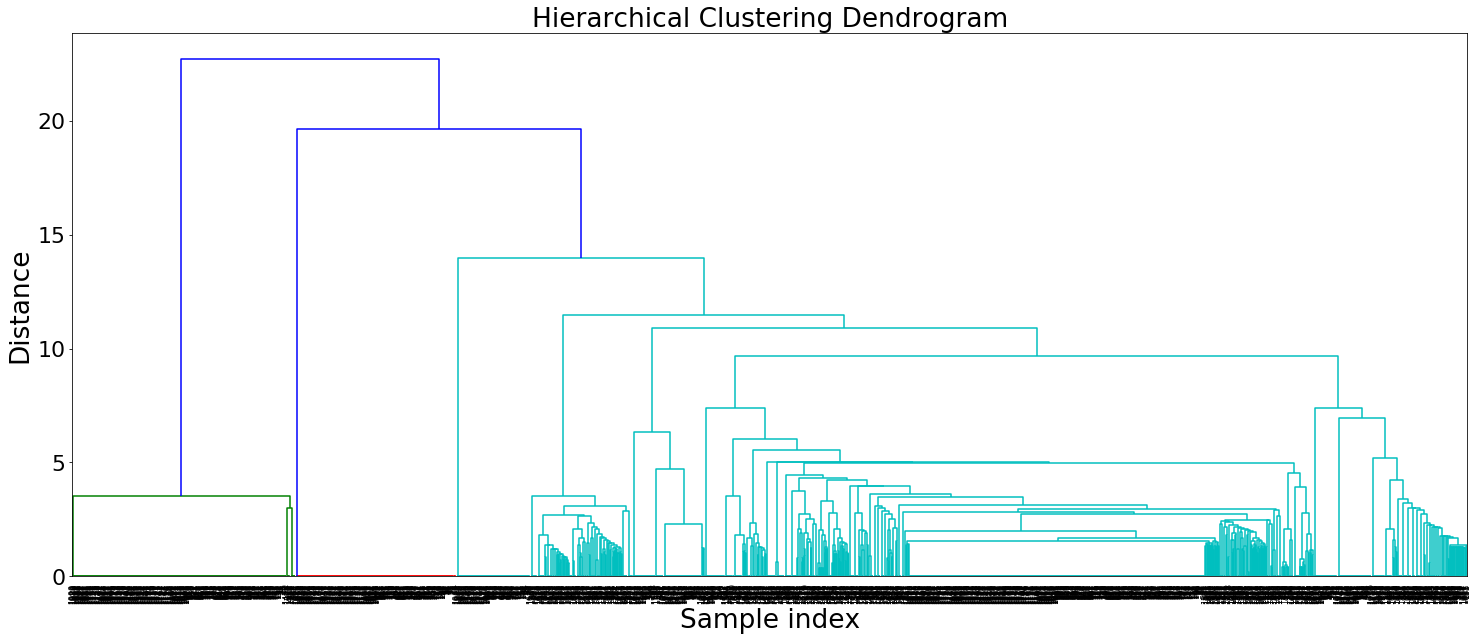

In [941]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram', fontsize='large')
plt.xlabel('Sample index', fontsize='large')
plt.ylabel('Distance', fontsize='large')
dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=8.,  
)
plt.show()

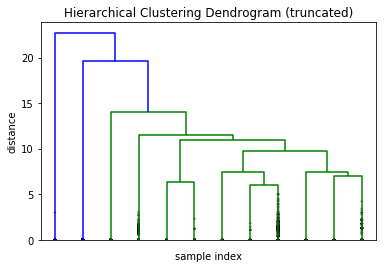

In [799]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  
)
plt.show()

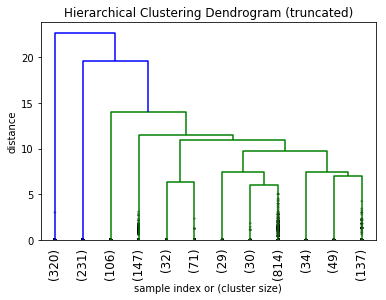

In [800]:
#Add information on the number of samples in each cluster
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
)
plt.show()

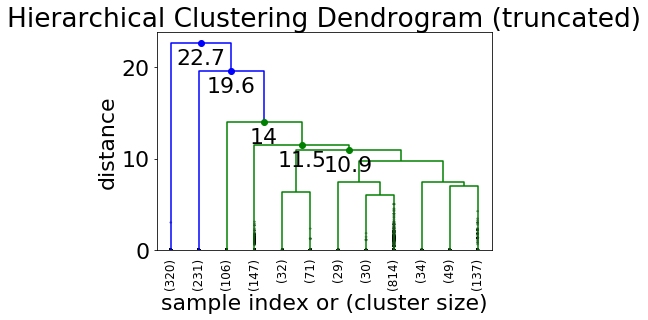

In [943]:
distance_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

In [944]:
max_d = 7  # max_d as in max_distance

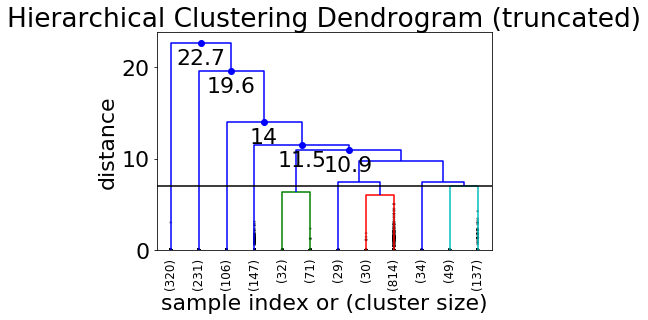

In [945]:
# plot a horizontal cut-off line
distance_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  
)
plt.show()


In [947]:
from scipy.cluster.hierarchy import fcluster
max_d = 7
clusters = fcluster(Z, max_d, criterion='distance')

In [948]:
#Output is array of cluster assignment for each sample
clusters

array([7, 1, 1, ..., 2, 7, 1], dtype=int32)

In [949]:
len(clusters)

2000

In [838]:
#The number of unique clusters identified by the algorithm
set(clusters)

{1, 2, 3, 4, 5, 6, 7, 8, 9}

### Get all data from each cluster

### Cluster 1

In [962]:
get_data_from_cluster(df_processed, clusters, 1)

320


exit_status  \
1     Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
2     Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
5     Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
24    Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
25    Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
44    Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
65    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
74    Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
77    Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
78    Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
99    Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
144   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
152   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
154   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
165   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
176   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
177   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
199   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
201   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
217   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
222   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
230   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
235   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
239   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
240   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
255   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
257   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
262   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
268   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
290   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
...                                                                                              ...     
1761  Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
1764  Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
1776  Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
1780  Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
1784  Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
1791  Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
1805  Command exited with non-zero status code (1):   ERROR: Co

### Cluster 2

In [963]:
get_data_from_cluster(df_processed, clusters, 2)

231


exit_status  \
4     Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
12    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
14    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
19    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
21    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
22    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
27    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
31    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
34    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
36    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
39    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
46    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
47    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
51    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
52    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
63    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
69    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
82    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
92    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
122   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
128   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
140   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
142   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
149   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
159   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
169   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
173   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
188   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
193   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
195   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
...                                                                                                ...   
1766  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1767  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1770  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1782  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1785  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1798  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1822  Command exited with non-zero status code (1):     ERROR: 

### Cluster 3

In [964]:
get_data_from_cluster(df_processed, clusters, 3)

106


exit_status  \
7     Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
10    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
35    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
40    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
41    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
45    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
56    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
84    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
94    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
100   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
118   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
120   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
124   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
131   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
141   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
145   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
151   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
162   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
166   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
181   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
185   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
202   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
242   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
251   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
273   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
300   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
308   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
384   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
388   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
405   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
...                                                                                                ...   
1375  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1383  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1410  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1418  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1429  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1430  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1451  Command exited with non-zero status code (1):     ERROR: 

### Cluster 4

In [965]:
get_data_from_cluster(df_processed, clusters, 4)

147


exit_status  \
20    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
28    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
29    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
81    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
104   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
106   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
117   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
148   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
180   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
197   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
212   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
224   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
233   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
237   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
244   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
278   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
279   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
286   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
299   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
316   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
323   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
343   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
353   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
357   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
376   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
379   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
380   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
391   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
393   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
413   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
...                                                                                                ...   
1655  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1670  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1673  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1689  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1690  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1691  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1726  Command exited with non-zero status code (1):     ERROR: 

### Cluster 5

In [966]:
get_data_from_cluster(df_processed, clusters, 5)

103


exit_status  \
3     Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
15    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
38    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
43    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
72    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
76    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
86    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
110   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
126   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
150   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
223   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
229   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
289   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
309   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
310   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
312   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
330   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
333   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
336   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
340   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
347   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
351   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
360   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
364   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
365   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
407   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
422   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
436   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
449   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
453   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
...                                                                                                ...   
1442  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1476  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1494  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1506  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1529  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1534  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1561  Command exited with non-zero status code (1):     ERROR: 

### Cluster 6

In [967]:
get_data_from_cluster(df_processed, clusters, 6)

29


exit_status  \
32    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
133   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
247   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
249   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
253   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
266   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
440   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
497   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
514   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
574   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
618   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
642   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
728   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
757   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
808   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
860   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
950   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
968   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1406  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1437  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1522  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1653  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1654  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1708  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1808  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1811  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1949  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1951  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1987  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   

                                   exit_status_ERROR  \
32    ERROR: Command errored out with exit status 1:   
133   ERROR: Command errored out with exit status 1:   
247   ERROR: Command errored out with exit status 1:   
249   ERROR: Command errored out with exit status 1:   
253   ERROR: Command errored out with exit status 1:   
266   ERROR: Command errored out with exit status 1:   
440   ERROR: Command errored out with exit status 1:   
497   ERROR: Command errored out with exit status 1:   
514   ERROR: Command errored out with exit status 1:   
574   ERROR: Command errored out with exit status 1:   
618   ERROR: Command errored out with exit status 1:   
642   ERROR: Command errored out with exit status 1:   
728   ERROR: Command errored out with exit status 1:   
757   ERROR: Command errored out with exit status 1:   
808   ERROR: Command errored out with exit status 1:   
860   ERROR: C

### Cluster 7- need further exploring

In [968]:
get_data_from_cluster(df_processed, clusters, 7)

844


exit_status  \
0     Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
8     Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:                                                                                                                                                                                                                                                                                                                     

### Cluster 8

In [969]:
get_data_from_cluster(df_processed, clusters, 8)

34


exit_status  \
17    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
23    Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
49    Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
73    Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
111   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
127   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
178   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
358   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
381   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
464   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
467   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
519   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
559   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
570   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
653   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
668   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
734   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
738   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
881   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
894   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
908   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
921   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
1039  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1122  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1163  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1252  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1259  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1434  Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
1546  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1574  Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
1630  Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
1680  Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
1686  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1959  Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     

                                   exit_status_ERROR  \
17    ERROR: Command errored out with exit status 1:   
23    ERROR: Command errored out with exit status 1:   
49    ERROR: Command errored out with exit status 1:   
73    ERROR: Command errored out with exit status 1:   
111   ERROR: Command errored out with exit status 1:   
127   ERROR: Command errored out with exit s

### Cluster 9

In [970]:
get_data_from_cluster(df_processed, clusters, 9)

186


exit_status  \
6     Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
16    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
33    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
58    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
59    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
60    Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
75    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
91    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
93    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
97    Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
108   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
109   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
121   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
132   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
134   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
136   Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
156   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
167   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
168   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
170   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
171   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
194   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
210   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
250   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
263   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
293   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
297   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
305   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
326   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
339   Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
...                                                                                                ...   
1688  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1709  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1713  Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
1721  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1722  Command exited with non-zero status code (1):   ERROR: Command errored out with exit status 1:     
1724  Command exited with non-zero status code (1):     ERROR: Command errored out with exit status 1:   
1738  Command exited with non-zero status code (1):     ERROR: 

### Finding a sample and predicting a cluster (future work)

## Links

https://towardsdatascience.com/nlp-for-beginners-cleaning-preprocessing-text-data-ae8e306bef0f

http://jonathansoma.com/lede/algorithms-2017/classes/clustering/k-means-clustering-with-scikit-learn/

https://towardsdatascience.com/machine-learning-algorithms-part-12-hierarchical-agglomerative-clustering-example-in-python-1e18e0075019

https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Hierarchical_Clustering-Dendrograms.pdf

https://www.displayr.com/what-is-hierarchical-clustering/

https://scikit-learn.org/0.18/auto_examples/text/document_clustering.html
